In [1]:
import comtypes.client

def connect_to_etabs():
    try:
        helper = comtypes.client.CreateObject('ETABSv1.Helper')
        helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)
        etabs_object = helper.GetObject("CSI.ETABS.API.ETABSObject") 
        return etabs_object.SapModel
    except Exception as e:
        print(f"Bağlantı Hatası: {e}")
        return None

sap_model = connect_to_etabs()

 Story Direction    Drift LoadCase Status
Story5         X 0.000096    EX_RP ✅ PASS
Story5         Y 0.000063    EX_RP ✅ PASS
Story4         X 0.000098    EX_RP ✅ PASS
Story4         Y 0.000067    EX_RP ✅ PASS
Story3         X 0.000090    EX_RP ✅ PASS
Story3         Y 0.000065    EX_RP ✅ PASS
Story2         X 0.000070    EX_RP ✅ PASS
Story2         Y 0.000056    EX_RP ✅ PASS
Story1         X 0.000047    EX_RP ✅ PASS
Story1         Y 0.000037    EX_RP ✅ PASS
Story5         Y 0.000155    EY_RP ✅ PASS
Story4         Y 0.000161    EY_RP ✅ PASS
Story3         Y 0.000151    EY_RP ✅ PASS
Story2         Y 0.000122    EY_RP ✅ PASS
Story1         Y 0.000062    EY_RP ✅ PASS


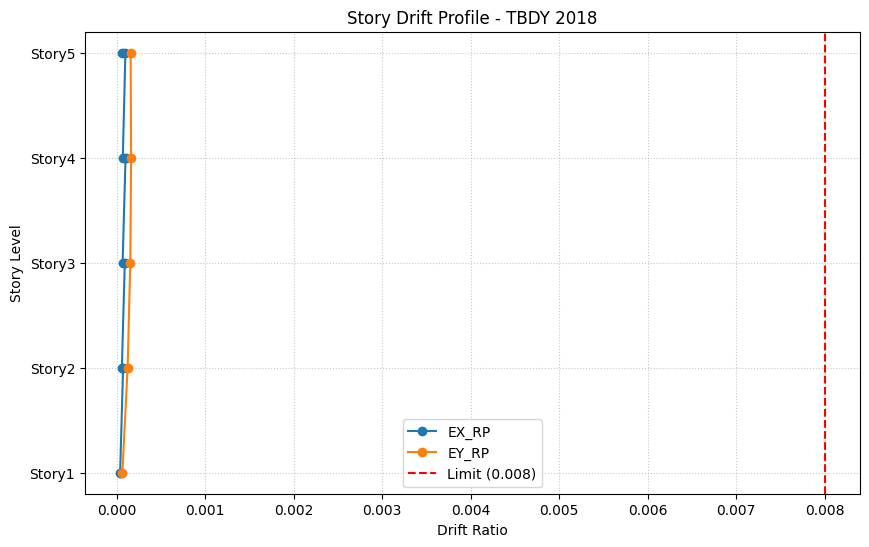

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def get_story_drifts(sap_model, load_case):
    """
    Extracts relative story drifts from the active ETABS model for a specific load case.
    Units are set to kN, m (Index 6).
    """
    sap_model.SetPresentUnits(6) 
    sap_model.Results.Setup.DeselectAllCasesAndCombosForOutput()
    ret = sap_model.Results.Setup.SetCaseSelectedForOutput(load_case)
    
    if ret != 0:
        return []
    
    # Retrieve results from ETABS API
    results = sap_model.Results.StoryDrifts()

    if not results or results[0] == 0:
        return []
    
    stories = results[1]
    directions = results[5]
    drifts = results[6]
    
    data_list = []
    for story, direction, drift in zip(stories, directions, drifts):
        data_list.append({
            "Story": story, 
            "Direction": direction, 
            "Drift": drift,
            "LoadCase": load_case
        })
    return data_list

# --- Execution and Analysis ---
if 'sap_model' in locals() and sap_model is not None:
    cases = ["EX_RP", "EY_RP"]
    combined_data = []

    for case in cases:
        drift_data = get_story_drifts(sap_model, case)
        combined_data.extend(drift_data)

    df_drifts = pd.DataFrame(combined_data)

    # TBDY 2018 Limit Check (0.008 for RC structures)
    drift_limit = 0.008  
    df_drifts["Status"] = df_drifts["Drift"].apply(
        lambda x: "✅ PASS" if x <= drift_limit else "❌ FAIL"
    )

    print(df_drifts.to_string(index=False))

    # --- Data Visualization ---
    plt.figure(figsize=(10, 6))
    for case in cases:
        # Filter by direction (e.g., only show primary direction for each case)
        subset = df_drifts[df_drifts["LoadCase"] == case].sort_values("Story")
        plt.plot(subset["Drift"], subset["Story"], marker='o', label=case)

    plt.axvline(x=drift_limit, color='r', linestyle='--', label=f'Limit ({drift_limit})')
    plt.title('Story Drift Profile - TBDY 2018')
    plt.xlabel('Drift Ratio')
    plt.ylabel('Story Level')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
else:
    print("Please connect to ETABS model first.")